Amir Mobayen
Deep Learning Final Exam

For the both networks, you should:
- **Create a test and validation set**
- **Preprocess the data**: While preprocessing is not the subject of this exam,wrong/poor preprocessing steps will be sanctioned.
- **Explain all of your choices with comments**: Why did you choose this preprocessing ? this architecture ? this hyperparameter ?
- **Compare different architectures**: Layer hyperparameters (activation function,initialization method, units), regularization methods (dropout, batch normalization, l1 l2 regularization, early stopping …), training hyperparameters (learning rate, batch size, optimizers …) …
- **Train the model and evaluate its performances on the test set**: The results should be shown in the Notebook.

Your project should be returned as a Notebook. No ZIP file.
**(Bonus Point)** Save your model.

In [1]:
import matplotlib.pyplot as plt
# Basic packages
import numpy as np
import pandas as pd
import os
import random

# Tensorflow
import tensorflow as tf
from numpy import ravel
from sklearn.compose import ColumnTransformer
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error


2023-06-18 10:10:56.096806: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-18 10:10:56.216474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 10:10:56.874268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Part One (Training On RNN)
- The Trip Advisor DataSet
- The Global Temperature DataSet

In [2]:
data = pd.read_csv('data/Global_Temperatures.csv', index_col=0)
data.describe(), data.head()

(       LandAverageTemperature
 count             3159.000000
 mean                 8.377803
 std                  4.378687
 min                 -2.080000
 25%                  4.318500
 50%                  8.618000
 75%                 12.548500
 max                 19.021000,
            dt  LandAverageTemperature
 0  1752-10-01                   7.839
 1  1752-11-01                   7.335
 2  1752-12-01                   5.086
 3  1753-01-01                   2.039
 4  1753-02-01                   0.715)

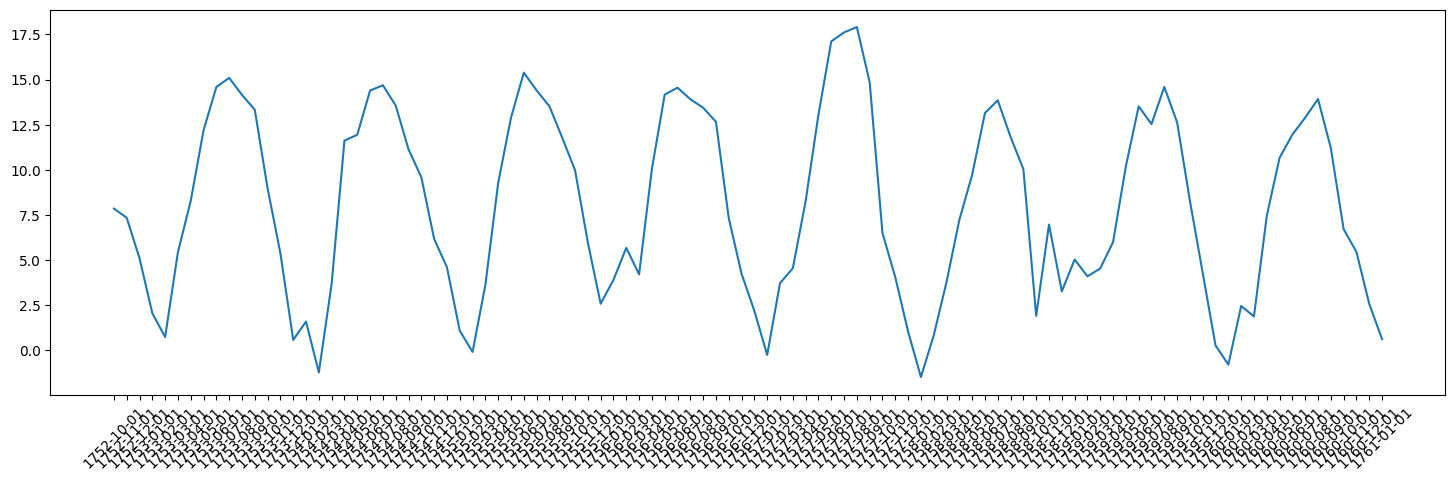

In [3]:
sample = data.head((100))
plt.figure(1, figsize=(18, 5))
plt.plot(sample['dt'], sample['LandAverageTemperature'])
plt.xticks(rotation=45)
plt.show()

In [8]:
# make a copy in order not to touch the original file
data_set = data.copy()

# make sure about data type:
data_set['dt'] = pd.to_datetime(data_set['dt'], infer_datetime_format=True)

# clean input data:
# remove null values on numerical columns
data_set = data_set.dropna()

# remove duplicates
data_set = data_set.drop_duplicates()

# data_set = data_set.to_numpy(dtype=float)
data_set

/tmp/ipykernel_7678/1001986738.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_set['dt'] = pd.to_datetime(data_set['dt'], infer_datetime_format=True)


,dt,LandAverageTemperature
0,1752-10-01,7.839
1,1752-11-01,7.335
2,1752-12-01,5.086
3,1753-01-01,2.039
4,1753-02-01,0.715
...,...,...
3154,2015-08-01,14.755
3155,2015-09-01,12.999
3156,2015-10-01,10.801
3157,2015-11-01,7.433


In [11]:
def prep_data(datain, time_step):
    # 1. y-array
    # First, create an array with indices for y elements based on the chosen time_step
    y_indices = np.arange(start=time_step, stop=len(datain), step=time_step)
    # Create y array based on the above indices
    y_tmp = datain[y_indices]

    # 2. X-array
    # We want to have the same number of rows for X as we do for y
    rows_X = len(y_tmp)
    # Since the last element in y_tmp may not be the last element of the datain,
    # let's ensure that X array stops with the last y
    X_tmp = datain[range(time_step * rows_X)]
    # Now take this array and reshape it into the desired shape
    X_tmp = np.reshape(X_tmp, (rows_X, time_step, 1))
    return X_tmp, y_tmp


def reset_seeds():
    os.environ['PYTHONHASHSEED'] = str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

In [10]:
scaler = StandardScaler()
X = data_set[['LandAverageTemperature']]
X_scaled = scaler.fit_transform(X)

train_data, test_data = train_test_split(X_scaled, test_size=0.2, shuffle=False)
time_step = 7
X_train, y_train = prep_data(train_data, time_step)
X_test, y_test = prep_data(test_data, time_step)

In [21]:
reset_seeds()
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([

    tf.keras.layers.InputLayer(input_shape=(time_step, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.MeanSquaredError())

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early])

Epoch 1/50
12/12 [==============================] - 1s 19ms/step - loss: 0.3567 - val_loss: 0.0830
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0761 - val_loss: 0.0801
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0605 - val_loss: 0.0973
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0568
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0552 - val_loss: 0.0525
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0493 - val_loss: 0.0517
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.0420 - val_loss: 0.0522
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0428 - val_loss: 0.0443
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0428 - val_loss: 0.0430
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0412 - val_loss: 0.0435
Epoch 11/50
12/12 

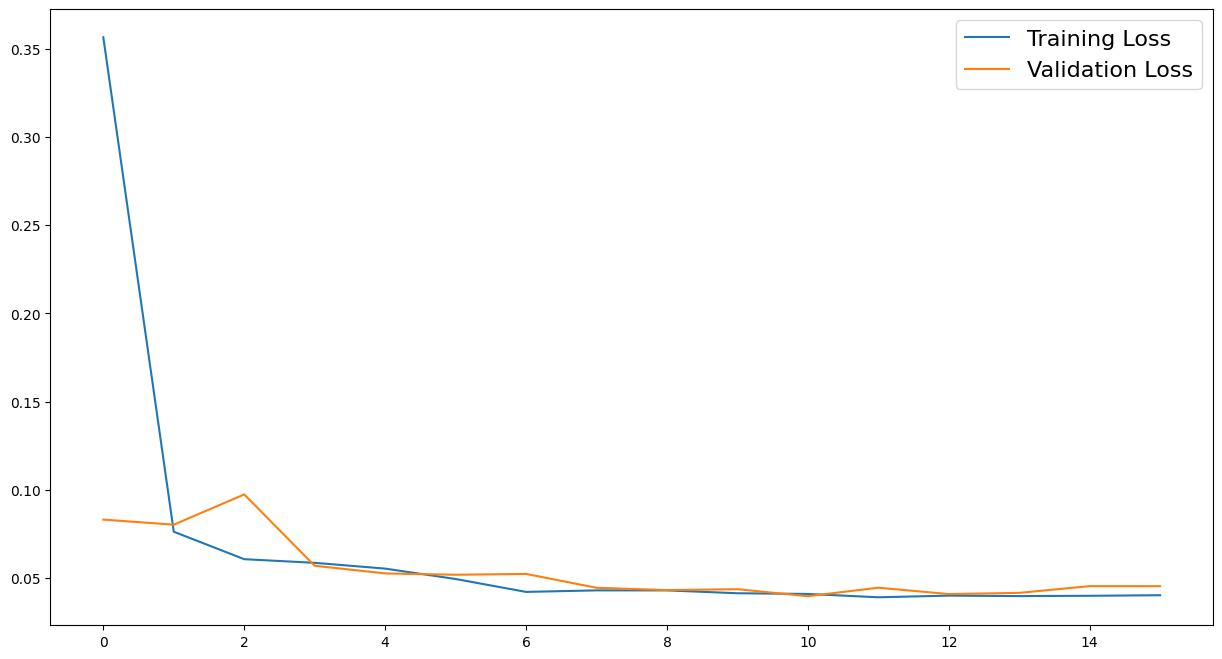

In [22]:
# Learning Curves
plt.figure(figsize=(15, 8))

plt.plot(np.arange(0, early.stopped_epoch + 1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(0, early.stopped_epoch + 1), history.history['val_loss'], label='Validation Loss')

plt.legend(fontsize=16)
plt.show()

In [23]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 1ms/step


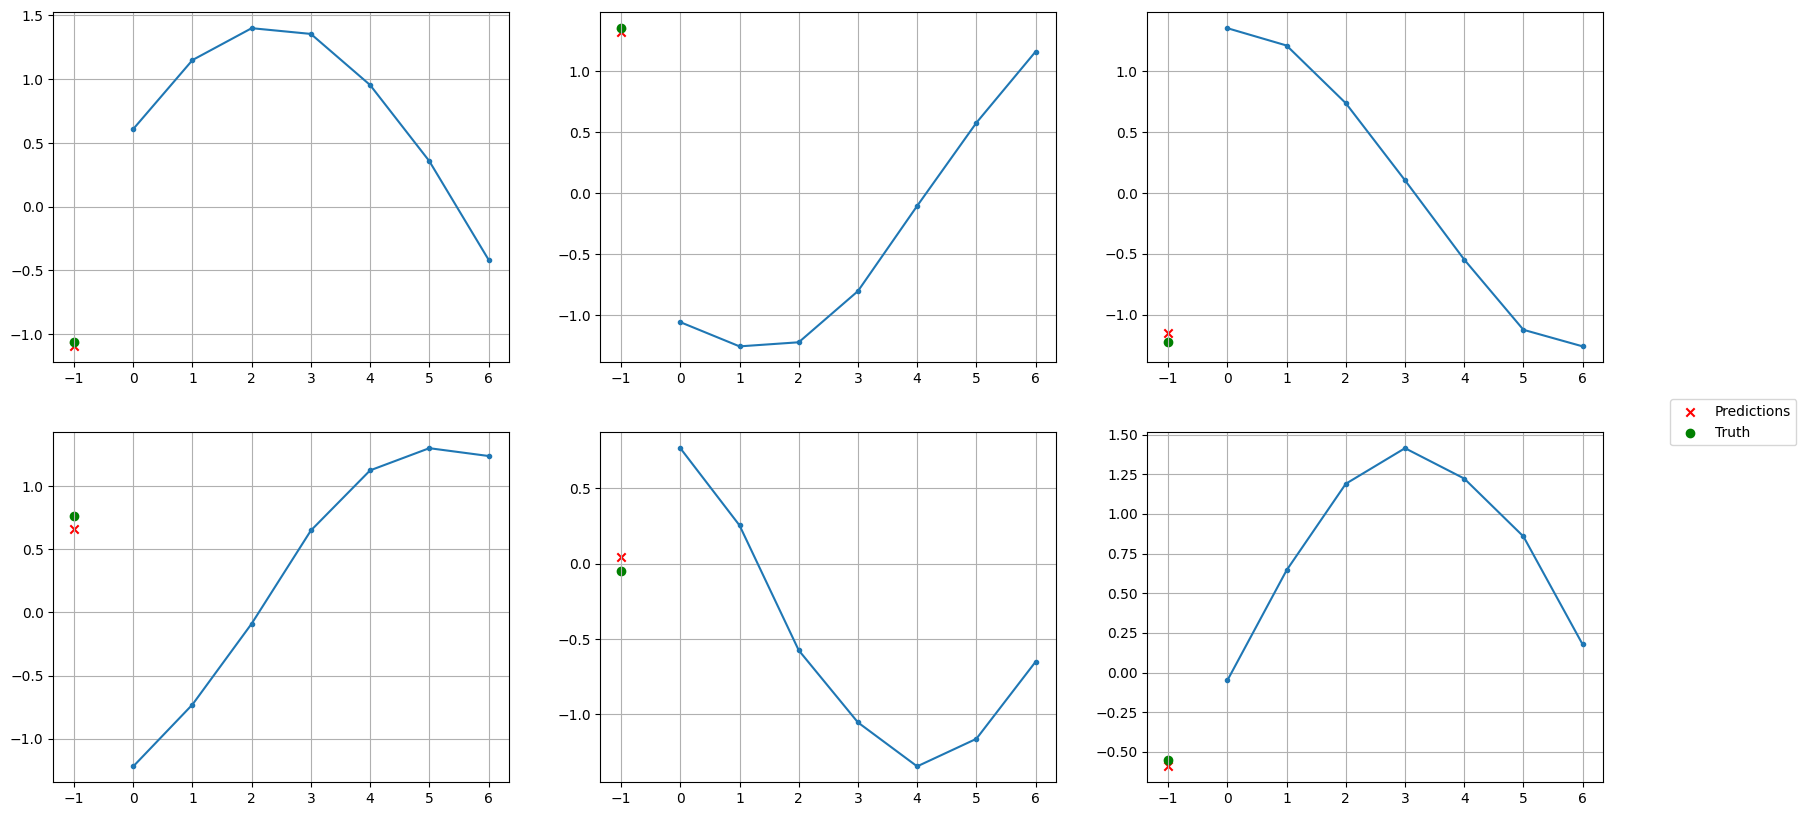

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(np.ravel(axs)):
    ax.plot(X_test[i, :], ".-")
    ax.scatter(np.array([-1]), y_pred[i], c='r', marker='x', label='Predictions')
    ax.scatter(np.array([-1]), y_test[i], c='g', marker='o', label='Truth')
    ax.grid()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 0.5))
plt.show()

In [25]:
print(f"Benchmark MSE : {mean_squared_error(y_pred, y_test):.4f}")

Benchmark MSE : 0.0395


# Part Two (Training On CNN)
The Corals DataSet
The Brain Tumor DataSet


In [ ]:
from PIL import Image
import pathlib

#
# not_tumor = pathlib.Path('data/Brain_Tumor/no').glob('*.png')
# tumor = pathlib.Path('data/Brain_Tumor/yes').glob('*.png')
image_data = pd.DataFrame()

tumor_directory = 'data/Brain_Tumor/yes'
not_tumor_directory = 'data/Brain_Tumor/no'
for filename in os.listdir(not_tumor_directory):
    if filename.endswith(".jpg".lower()) or filename.endswith(".jpeg".lower()):
        file_path = os.path.join(not_tumor_directory, filename)
        img = Image.open(file_path)
        img_array = np.array(img)
        img_reshaped = img_array.reshape(-1)
        img_data = pd.DataFrame(img_reshaped).T
        img_data['Width'] = img.width
        img_data['Height'] = img.height
        img_data['status'] = 0

image_data

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image

# Load the image
img_path = 'path_to_your_image.jpg'  # Replace with the actual image file path
img = Image.open(img_path)

# Convert the image to a NumPy array
img_array = np.array(img)

# Reshape the array to have one row per pixel
img_reshaped = img_array.reshape(-1, 3)  # Assuming RGB image, change "3" to "1" for grayscale images

# Create a Pandas DataFrame from the reshaped array
image_data = pd.DataFrame(img_reshaped, columns=['Red', 'Green', 'Blue'])  # Change column names accordingly

# Add additional columns if needed, e.g., width, height, etc.
image_data['Width'] = img.width
image_data['Height'] = img.height

# Display the DataFrame
print(image_data)
